# Determination poisonous mushrooms from edible ones

<img src="aid9553804-v4-728px-Identify-Edible-Mushrooms-Step-2.jpg" style="width:400px;height:200px"/>


## ***Preparing Environment***

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:

#!kaggle datasets download -d uciml/mushroom-classification
!kaggle datasets download -d uciml/mushrooms

404 - Not Found


In [ ]:
!ls

kaggle.json  mushrooms.csv


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(123)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:


!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


# ***Data Preparation***

In [ ]:

data=pd.read_csv("mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Notice, there is no null values in any of the columns, and all features are categorical! However, most of the variables are objects, but we know `bruises` is a boolean variable. So, we convert it accordingly below:


In [ ]:
data.replace({'bruises': {'t': True, 'f': False}}, inplace=True)
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,True,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,True,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,True,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,True,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,False,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
data["class"].value_counts()

e    4208
p    3916
Name: class, dtype: int64

In [ ]:
print(((sum(data["class"]=="p"))/8124)*100)
print(((sum(data["class"]=="e"))/8124)*100)

48.20285573609059
51.7971442639094


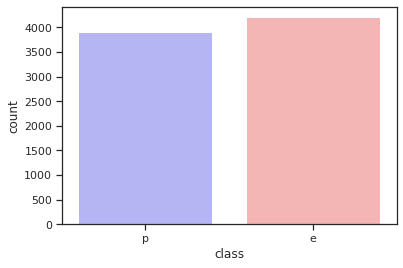

In [ ]:
df = data.copy()
sns.set(style="ticks")
f = sns.countplot(x="class", data=df, palette="bwr")
plt.show()

Since the ratio of class edible to poisonous is very close (48.2 : 52.8), we know can say that the dataset is not imbalanced.

In [ ]:
data.shape

(8124, 23)

In [ ]:
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,False,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Since "veil-type" has just one class, we can remove it.


In [ ]:
data.drop("veil-type",1,inplace=True)

In [ ]:
data.shape

(8124, 22)

In [ ]:
target = "class"
all_columns = [col for col in data.columns if col != target]
all_classes = data[target].unique()

To begin the exploration, let us look at the histograms to see the distribution of all variables:

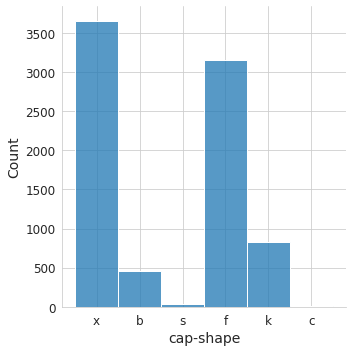

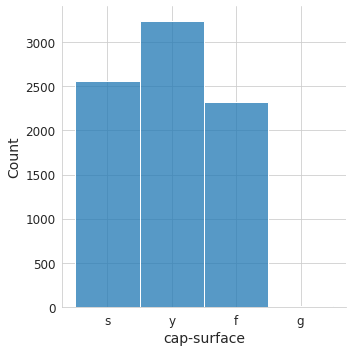

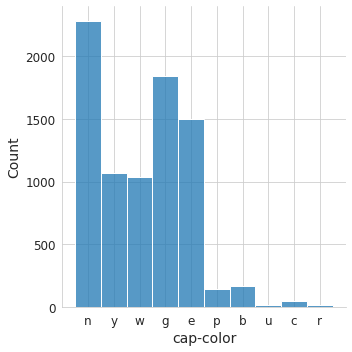

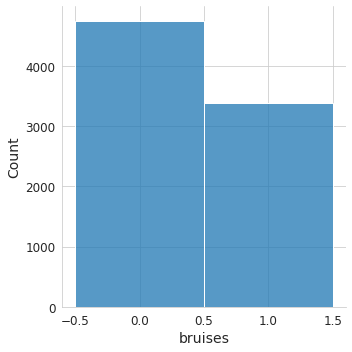

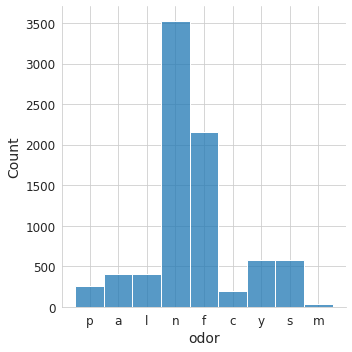

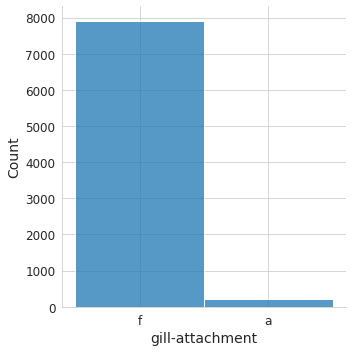

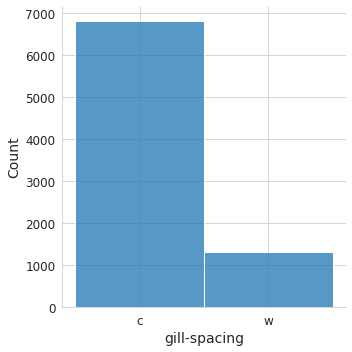

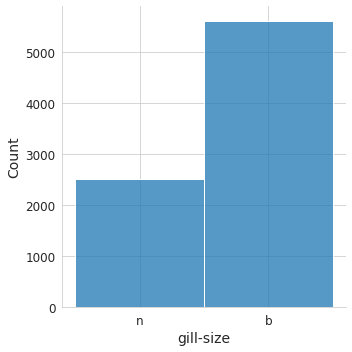

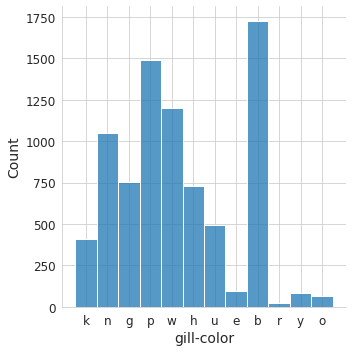

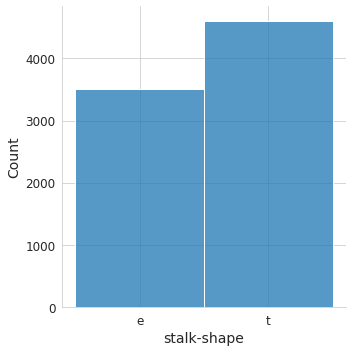

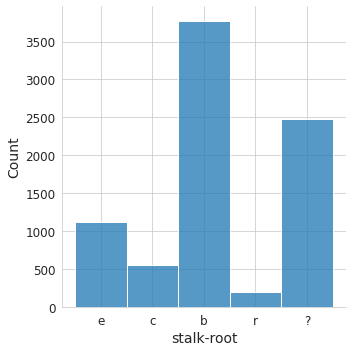

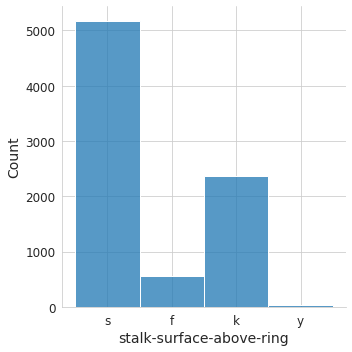

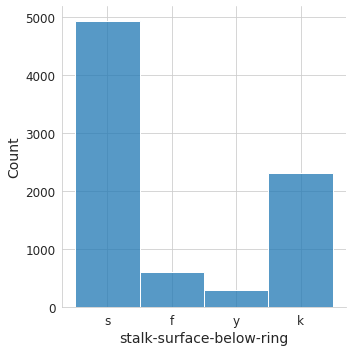

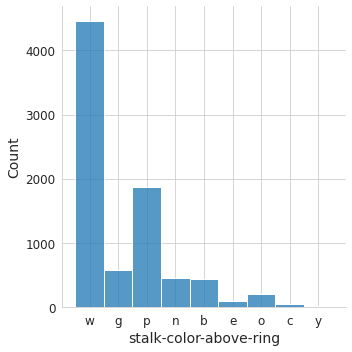

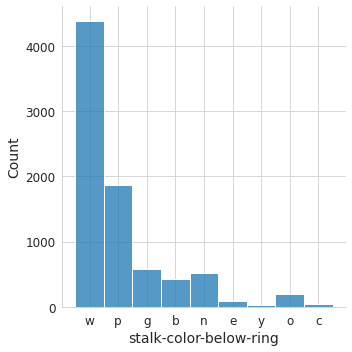

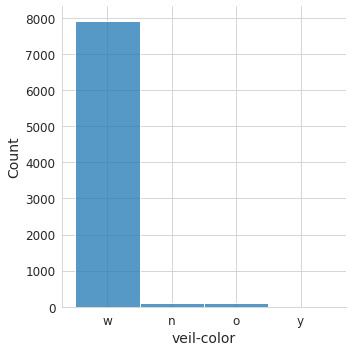

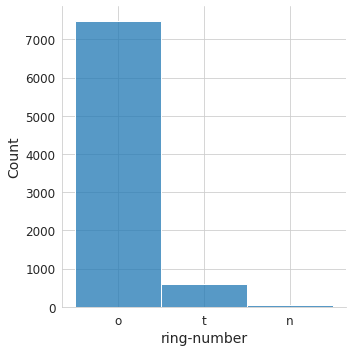

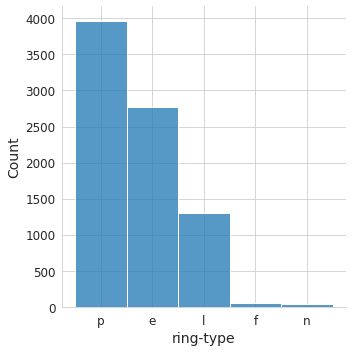

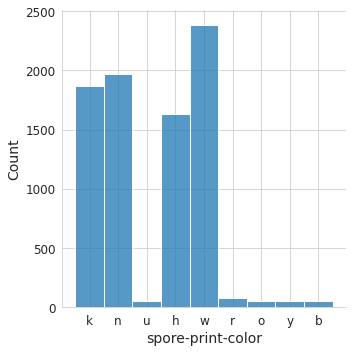

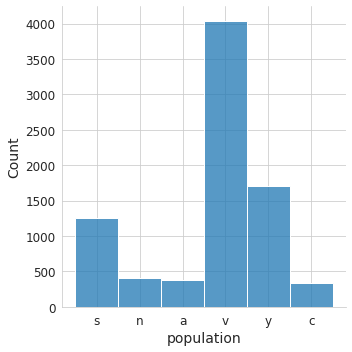

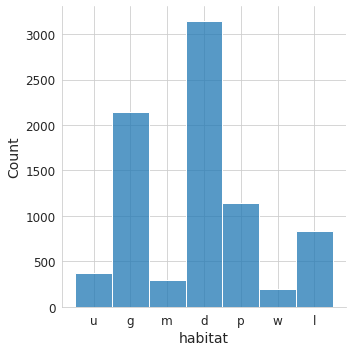

In [ ]:
import warnings
warnings.filterwarnings("ignore")

n = len(all_columns)

for i in range(n):
  sns.displot(data, x=all_columns[i], discrete=True)

From the initial inspection of all the variables, notice that some of the feature categories are extremely rare. This means that when training models using it, the numberical scale might be too different, resulting in imbalances during training procedures. Hence, we will club togther categories in each feature for better training. This includes:
- `cap-shape`: *s* and *c* are rare, so will be clubbed together in a category called *sc*
- `cap-color`: *u*, *c* and *r* are rare, so will be clubbed together in a category called *ucr*
- `odor`: *c* and *m* are rare, so will be clubbed together in a category called *cm*
- `gill-color`: *r*, *y* and *o* are rare, so will be clubbed together in a category called *ryo*
- `stalk-color-above-ring`: *e*, *c* and *y* are rare, so will be clubbed together in a category called *ecy*
- `stalk-color-below-ring`: *e*, *c* and *y* are rare, so will be clubbed together in a category called *ecy*
- `ring-type`: *f* and *n* are rare, so will be clubbed together in a category called *fn*
- `spore-print-color`: *u*, *o*, *y* and *b* are rare, so will be clubbed together in a category called *uoyb*

In [ ]:
data.loc[(data["cap-shape"] == "s") | (data["cap-shape"] == "c"), "cap-shape"] = "sc"
data.loc[(data["cap-color"] == "u") | (data["cap-color"] == "c") | (data["cap-color"] == "r"), "cap-color"] = "ucr"
data.loc[(data["odor"] == "m") | (data["odor"] == "c"), "odor"] = "cm"
data.loc[(data["gill-color"] == "r") | (data["gill-color"] == "y") | (data["gill-color"] == "o"), "gill-color"] = "ryo"
data.loc[(data["stalk-color-above-ring"] == "e") | (data["stalk-color-above-ring"] == "c") | (data["stalk-color-above-ring"] == "y"), "stalk-color-above-ring"] = "ecy"
data.loc[(data["stalk-color-below-ring"] == "e") | (data["stalk-color-below-ring"] == "c") | (data["stalk-color-below-ring"] == "y"), "stalk-color-below-ring"] = "ecy"
data.loc[(data["ring-type"] == "f") | (data["ring-type"] == "n"), "ring-type"] = "fn"
data.loc[(data["spore-print-color"] == "u") | (data["spore-print-color"] == "o") | (data["spore-print-color"] == "y") | (data["spore-print-color"] == "b"), "spore-print-color"] = "uoyb"
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,True,p,f,c,n,k,e,e,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,True,a,f,c,b,k,e,c,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,True,l,f,c,b,n,e,c,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,True,p,f,c,n,n,e,e,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,False,n,f,w,b,k,t,e,s,s,w,w,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,False,n,a,c,b,ryo,e,?,s,s,o,o,o,o,p,uoyb,c,l
8120,e,x,s,n,False,n,a,c,b,ryo,e,?,s,s,o,o,n,o,p,uoyb,v,l
8121,e,f,s,n,False,n,a,c,b,n,e,?,s,s,o,o,o,o,p,uoyb,c,l
8122,p,k,y,n,False,y,f,c,n,b,t,?,s,k,w,w,w,o,e,w,v,l


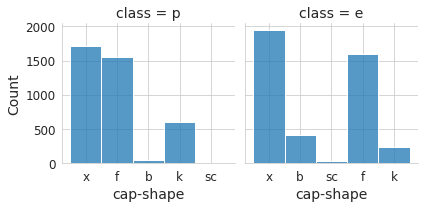

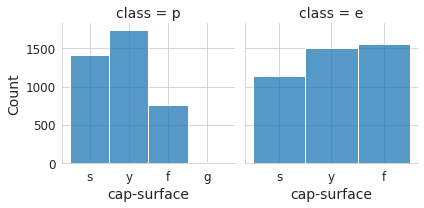

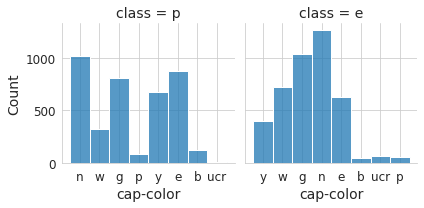

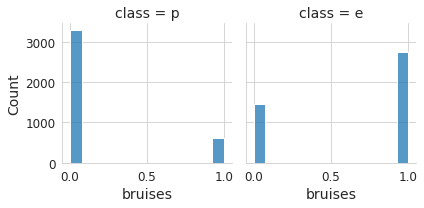

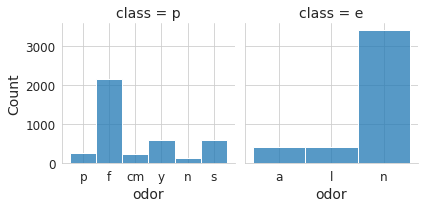

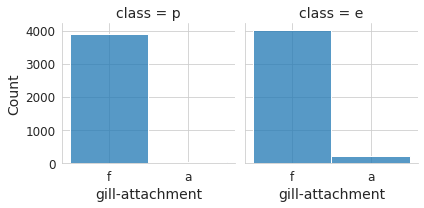

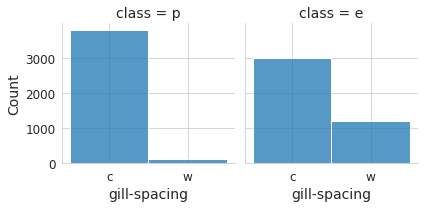

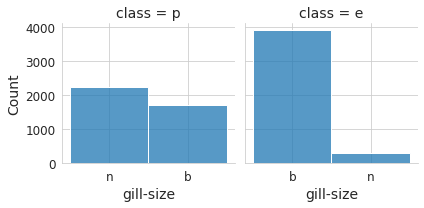

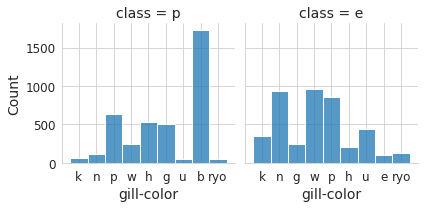

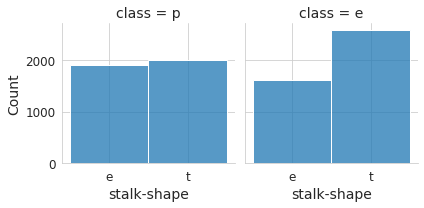

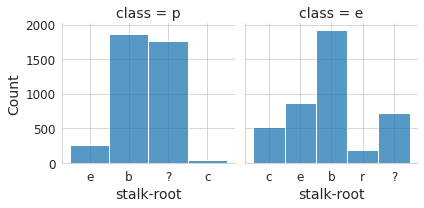

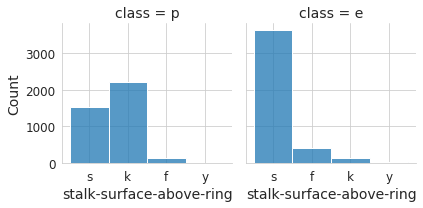

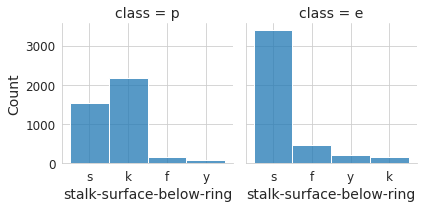

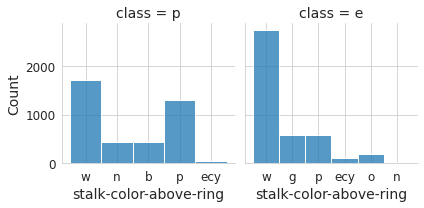

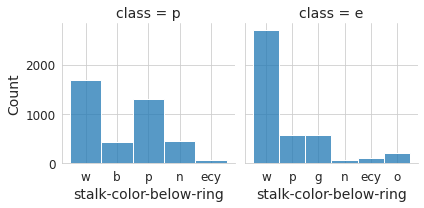

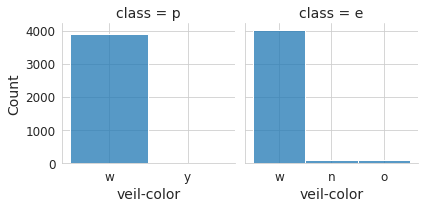

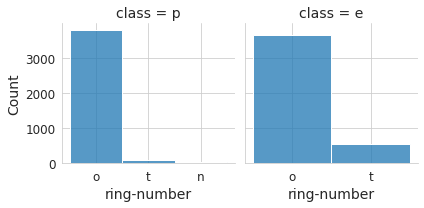

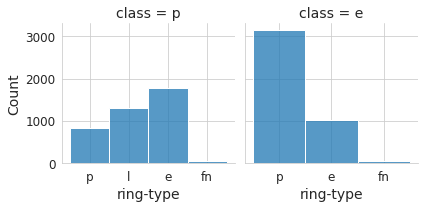

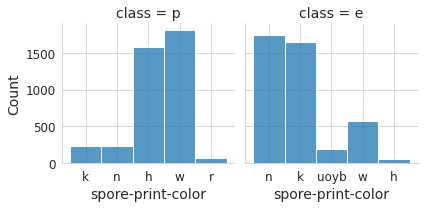

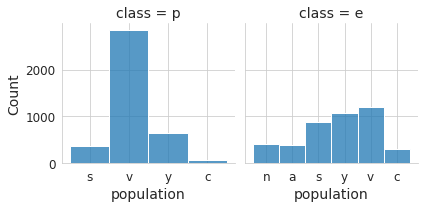

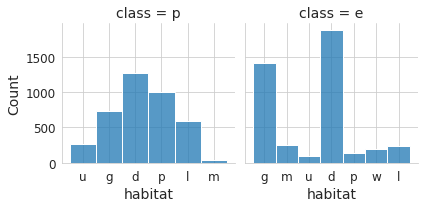

In [ ]:
for i in range(n):
  g = sns.FacetGrid(data, col=target, sharex='col')
  g.map(sns.histplot, all_columns[i])

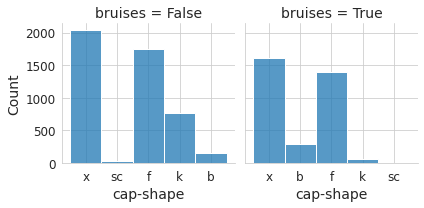

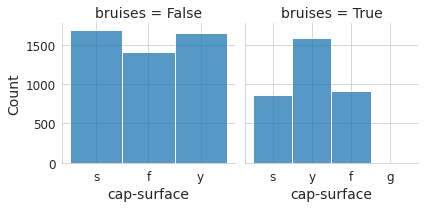

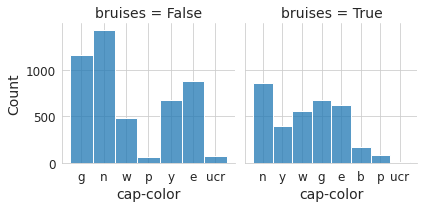

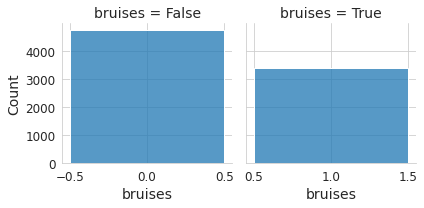

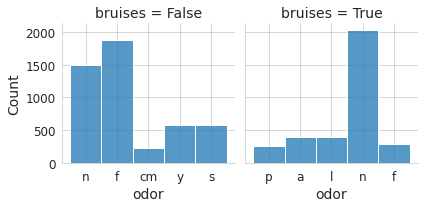

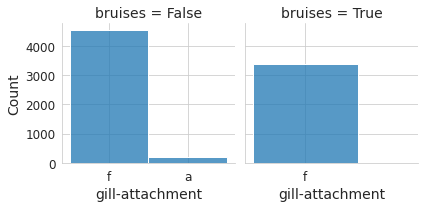

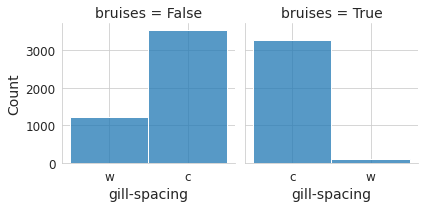

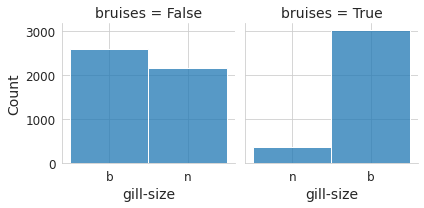

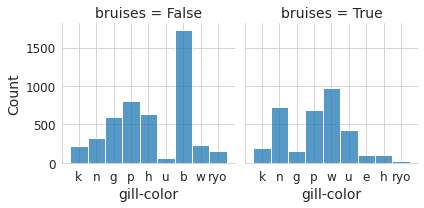

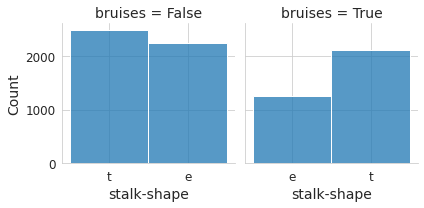

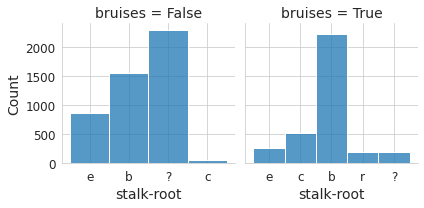

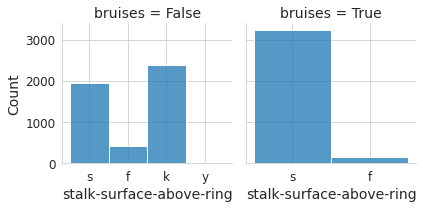

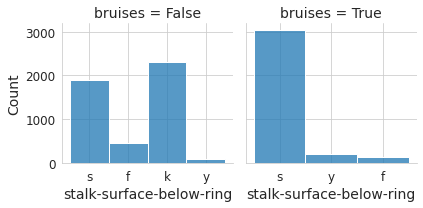

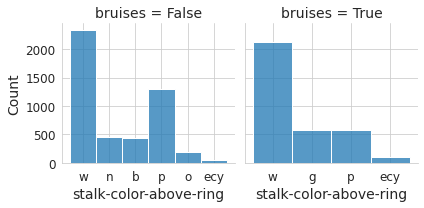

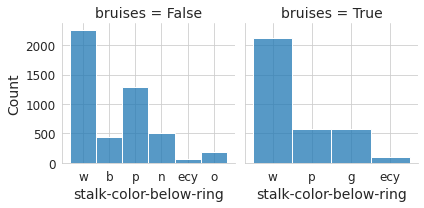

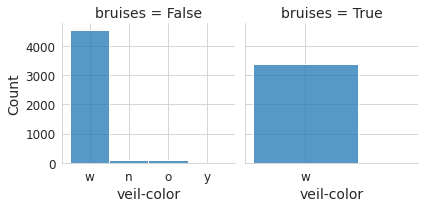

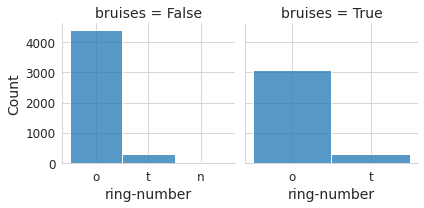

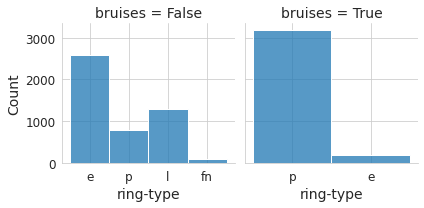

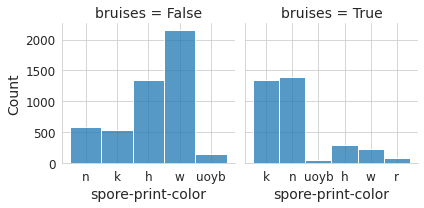

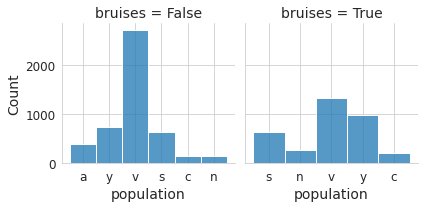

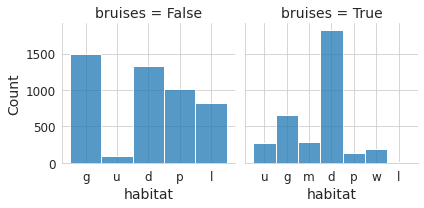

In [ ]:
for i in range(n):
  g = sns.FacetGrid(data, col="bruises", sharex='col')
  g.map(sns.histplot, all_columns[i])

In [ ]:
!pip install dython

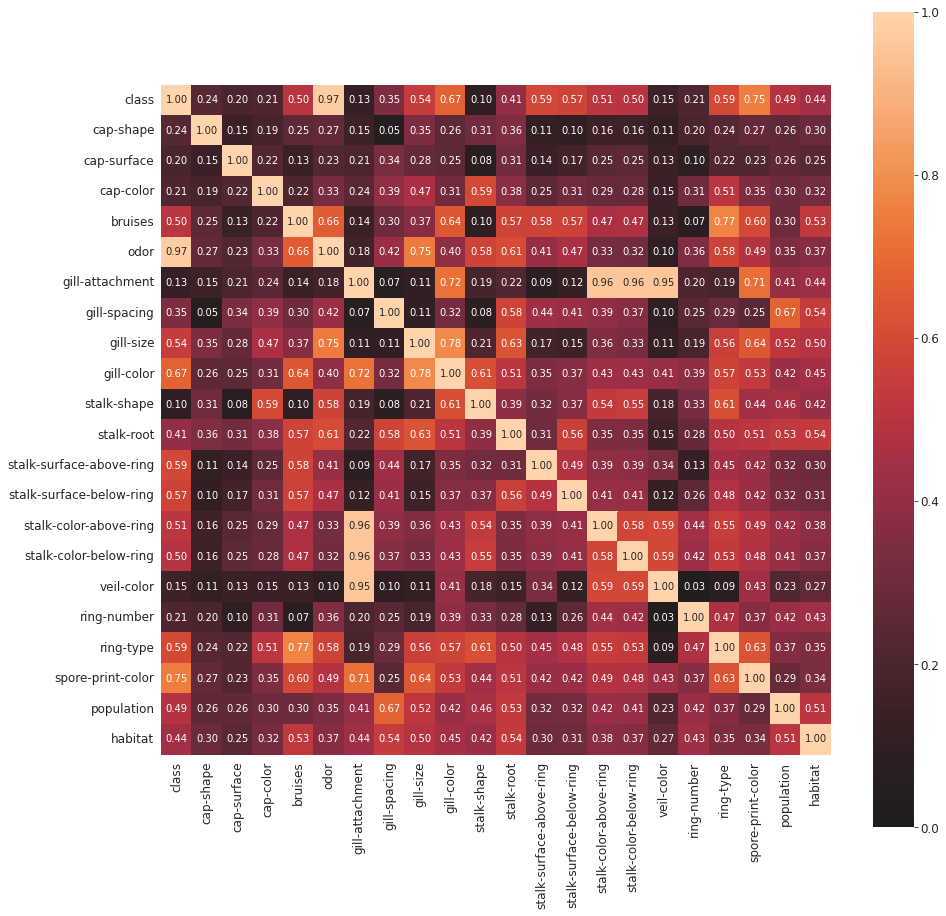

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd0ddc36b90>,
 'corr':                              class  cap-shape  ...  population   habitat
 class                     1.000000   0.240971  ...    0.486775  0.439323
 cap-shape                 0.240971   1.000000  ...    0.263418  0.296152
 cap-surface               0.195997   0.147591  ...    0.260952  0.249577
 cap-color                 0.214883   0.186508  ...    0.302529  0.322936
 bruises                   0.501530   0.254723  ...    0.300576  0.530920
 odor                      0.970621   0.268917  ...    0.346899  0.369028
 gill-attachment           0.127951   0.153391  ...    0.413362  0.435707
 gill-spacing              0.347897   0.054325  ...    0.673533  0.541961
 gill-size                 0.539677   0.346134  ...    0.517249  0.498616
 gill-color                0.673696   0.255042  ...    0.418195  0.449775
 stalk-shape               0.101170   0.306320  ...    0.455486  0.417101
 stalk-root                0.406224   

In [ ]:
from dython.nominal import associations
associations(data,figsize=(15,15))

As it is shown in the correlation plot, the following features have a correlation with "class" in descending order: 
- odor
- spore-print-color
- gill-color
- gill-size
- ring-type
- stalk-surface-above-ring
- stalk-surface-below-ring
- stalk-color-above-ring
- stalk-color-below-ring
- bruises
- population

In [ ]:
data_f=data[["odor",'spore-print-color',"gill-color","gill-size","ring-type","stalk-surface-above-ring","stalk-surface-below-ring","stalk-color-above-ring","bruises","population"]]
 

# ***Model Design & Evalution***

In [ ]:
import scipy
from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [ ]:
# Splitting data_f

X_f=data_f.iloc[:,1:]
y=data.iloc[:,0]
X_f_train, X_f_test, y_train, y_test = train_test_split(X_f, y, test_size=0.2, random_state=0)

print(X_f_train.shape, X_f_test.shape, y_train.shape, y_test.shape)

(6499, 9) (1625, 9) (6499,) (1625,)


In [ ]:
# Splitting data

X=data.iloc[:,1:]
y=data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6499, 21) (1625, 21) (6499,) (1625,)


In [ ]:
# Preprocessing data
# We have just categorical features and no missing data, so pipeline include just encoding:

var_cat=list(data.iloc[:,1:].columns)
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, var_cat)]

In [ ]:
# Preprocessing data_f
# We have just categorical features and no missing data, so pipeline include just encoding:

var_cat=list(data_f.iloc[:,1:].columns)
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, var_cat)]


In [ ]:
#Pipeline data
# Pipeline

ct = ColumnTransformer(transformers=cat_transformers )
ct.fit(X_train)
X_train_tr = ct.transform(X_train)
X_test_tr = ct.transform(X_test)
print(X_train.shape)
print(X_train_tr.shape)
print(X_test.shape)
print(X_test_tr.shape)

(6499, 21)
(6499, 45)
(1625, 21)
(1625, 45)


In [ ]:
#Pipeline data_f
# Pipeline

ct = ColumnTransformer(transformers=cat_transformers )
ct.fit(X_f_train)
X_f_train_tr = ct.transform(X_f_train)
X_f_test_tr = ct.transform(X_f_test)
print(X_f_train.shape)
print(X_f_train_tr.shape)
print(X_f_test.shape)
print(X_f_test_tr.shape)
     

(6499, 9)
(6499, 45)
(1625, 9)
(1625, 45)


# ***SVM Model***

Support vector machine is the algorithem that is used for suppervised problem.The option of different kernels is one the advantages of this model. Here we used this model on data that is original data and data_f that is the data included just high correlated features by output.











In [ ]:
#SVM model data(kernel="linear")

from sklearn.metrics import accuracy_score
svm_clf = svm.SVC(kernel="linear", C=1,probability=True)
svm_clf.fit(X_train_tr, y_train)
print("SVM accuracy with linear kernel: " + str(classification_report(svm_clf.predict(X_test_tr), y_test)))
print("SVM accuracy with linear kernel: " + str(accuracy_score(svm_clf.predict(X_test_tr), y_test)))

SVM accuracy with linear kernel:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       832
           1       1.00      0.97      0.99       793

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

SVM accuracy with linear kernel: 0.9876923076923076


In [ ]:
#SVM model data_f(kernel="linear")

from sklearn.metrics import accuracy_score
svm_clf = svm.SVC(kernel="linear", C=1,probability=True)
svm_clf.fit(X_f_train_tr, y_train)
print("SVM accuracy with liner kernel: " + str(classification_report(svm_clf.predict(X_f_test_tr), y_test)))
print("SVM accuracy with linear kernel: " + str(accuracy_score(svm_clf.predict(X_f_test_tr), y_test)))

SVM accuracy with liner kernel:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       832
           1       1.00      0.97      0.99       793

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625

SVM accuracy with linear kernel: 0.9876923076923076


As our dataset is balance ,accuracy_score can be an appropriate metric for evaluation of model.Here The score of 0.99 shows the high performance of this model.

We are going to show the efficiency with other metrics like confusion metrix and ROC curve.

In [ ]:
#ROC (scoring)
#As detecting poisonous mushrooms can be a health consideration, the number of FN should be very important ,so by plotting ROC we are going to see how we can select a threshold to have minimum FN or maximum TP  .
#As it is clear the default threshold (=0.5)is in maximum TPR,so we do not need to customize it.

from sklearn.metrics import roc_curve
model_sv=svm.SVC(kernel="linear", C=1,probability=True).fit(X_train_tr, np.ravel(y_train))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), model_sv.predict_proba(X_test_tr)[:,1],pos_label='p')

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.legend(loc=4)


TypeError: ignored

In [ ]:
# Threshold plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(thresholds,fpr, color='tab:blue',label="fpr")
ax.plot(thresholds,tpr, color='tab:orange',label="tpr")
ax.set_xlim([0,1])
plt.legend(loc=4);
# As it is clear we do not need have custom threshold ,because we already have maximum TPR in threshold=0.5(default Threshold)

In [ ]:
# Scoring (SVM model)

from sklearn.metrics import accuracy_score, confusion_matrix
y_pr = svm_clf.fit(X_train_tr, y_train).predict(X_test_tr)
plt.title('Confusion matrix for SVM classifier(Linear)')

sns.heatmap(confusion_matrix(y_test, y_pr), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()
# The number of FN is zero.

In [ ]:
#SVM model(kernel="poly")

svm_clf = SVC(kernel="poly", degree=9, coef0=7, C=20)
svm_clf.fit(X_train_tr, y_train)
print("SVM accuracy with polynomial kernel: " + str(accuracy_score(svm_clf.predict(X_test_tr), y_test)))
print("SVM accuracy with Gaussian kernel: " + str(classification_report(svm_clf.predict(X_test_tr), y_test)))

In [ ]:
# SVM model(kernel="rbf")

svm_clf = SVC(kernel="rbf", gamma=1, C=20)
svm_clf.fit(X_train_tr, y_train)
print("SVM accuracy with Gaussian kernel: " + str(classification_report(svm_clf.predict(X_test_tr), y_test)))
print("SVM accuracy with Gaussian kernel: " + str(accuracy_score(svm_clf.predict(X_test_tr), y_test)))

# ***Logistic Regression***

For this model first we did hyperparamether.

In [ ]:
# Logistic Regression Hyperparamether

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid={ "max_iter":[100,1000,2500,5000],"solver":["newton-cg", "lbfgs",  "sag", "saga"],"penalty":[ "l2", "none"]}
clf=GridSearchCV(LogisticRegression(),param_grid,n_jobs=-1,cv=3,verbose=True)
best_clf=clf.fit(X_train_tr,y_train)
best_clf.best_params_


Fitting 3 folds for each of 32 candidates, totalling 96 fits


{'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}

In [ ]:
# Logistic Regression on data

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf=LogisticRegression(max_iter= 100, penalty="none", solver="newton-cg").fit(X_train_tr,y_train)
print(" Accuracy with LogisticRegression: " + str(accuracy_score(svm_clf.predict(X_test_tr), y_test)))
print("Accuracy with Logistic Regression: " + str(classification_report(svm_clf.predict(X_test_tr), y_test)))

 Accuracy with LogisticRegression: 0.9895384615384616
Accuracy with Logistic Regression:               precision    recall  f1-score   support

           e       0.98      1.00      0.99       835
           p       1.00      0.98      0.99       790

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



In [ ]:
# Logistic Regression on data_f

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf=LogisticRegression(max_iter= 100, penalty="l2", solver="newton-cg").fit(X_f_train_tr,y_train)
print(" Accuracy with LogisticRegression: " + str(accuracy_score(svm_clf.predict(X_f_test_tr), y_test)))
print("Accuracy with Logistic Regression: " + str(classification_report(svm_clf.predict(X_test_tr), y_test)))

 Accuracy with LogisticRegression: 0.9895384615384616
Accuracy with Logistic Regression:               precision    recall  f1-score   support

           e       0.98      1.00      0.99       835
           p       1.00      0.98      0.99       790

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



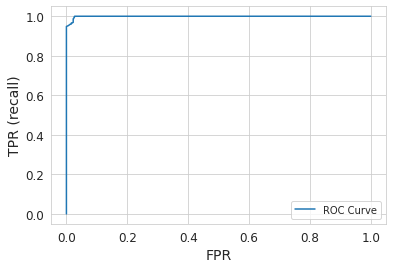

In [ ]:
#ROC (scoring) LR
#As detecting poisonous mushrooms can be a health consideration, the number of FN should be very important ,so by plotting ROC we are going to see how we can select a threshold to have minimum FN or TP in maximum.

from sklearn.metrics import roc_curve
clf=LogisticRegression(max_iter= 100, penalty="l2", solver="newton-cg").fit(X_train_tr,y_train)
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), clf.predict_proba(X_test_tr)[:,1],pos_label='p')

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.legend(loc=4)


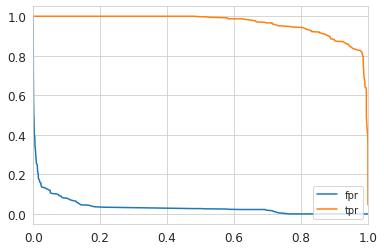

In [ ]:
# Threshold plot 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(thresholds,fpr, color='tab:blue',label="fpr")
ax.plot(thresholds,tpr, color='tab:orange',label="tpr")
ax.set_xlim([0,1])
plt.legend(loc=4);
# As it is clear we do not need have custom threshold ,because we already have maximum TPR in threshold=0.5(default Threshold)

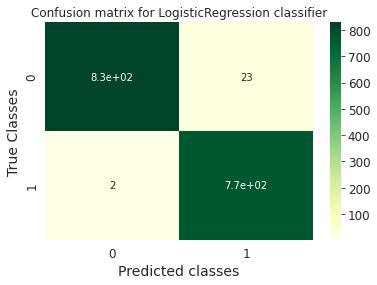

In [ ]:
# Confusion matrix LogisticRegression

y_pr = LogisticRegression(solver="lbfgs", max_iter=500).fit(X_train_tr, y_train).predict(X_test_tr)
plt.title('Confusion matrix for LogisticRegression classifier')

sns.heatmap(confusion_matrix(y_test, y_pr), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()


# ***Learning Curve for SVM & Logistic Regression Model***

Learning curve will help us to see if there is overfitting or underfitting problem.

In [ ]:
# Learning Curve for Logistic Regression

from sklearn.model_selection import learning_curve
train_sizes=np.linspace(0.1,1, 20)
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(),X_train_tr,y_train,cv=5,n_jobs=1,train_sizes=train_sizes)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)    

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

     

NameError: ignored

In [ ]:
# Learning Curve for SVM Model

train_sizes=np.linspace(0.1,1, 20)
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(kernel="linear", C=1),X_train_tr,y_train,cv=5,n_jobs=1,train_sizes=train_sizes)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)    

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()
# As there is no big gap between train_score and test_score and both train and test score are high ,there is no overfitting nor underfitting.

# ***Clustering***

In [ ]:
# Clustering (t_SNE)
# We did tSNE on 2 compounds to see the cluster visually, it seems we have separated clusters that can classify the poisonous and eddible mushrooms accrately.

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
import time
time_start = time.time()


tfmr = OneHotEncoder(sparse=False)
data_t=tfmr.fit_transform(data)
data_c=data_t[:,1:]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(data_c)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8124 samples in 0.001s...
[t-SNE] Computed neighbors for 8124 samples in 1.551s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8124
[t-SNE] Computed conditional probabilities for sample 2000 / 8124
[t-SNE] Computed conditional probabilities for sample 3000 / 8124
[t-SNE] Computed conditional probabilities for sample 4000 / 8124
[t-SNE] Computed conditional probabilities for sample 5000 / 8124
[t-SNE] Computed conditional probabilities for sample 6000 / 8124
[t-SNE] Computed conditional probabilities for sample 7000 / 8124
[t-SNE] Computed conditional probabilities for sample 8000 / 8124
[t-SNE] Computed conditional probabilities for sample 8124 / 8124
[t-SNE] Mean sigma: 0.934960
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.742699
[t-SNE] KL divergence after 300 iterations: 2.737961
t-SNE done! Time elapsed: 24.883044481277466 seconds


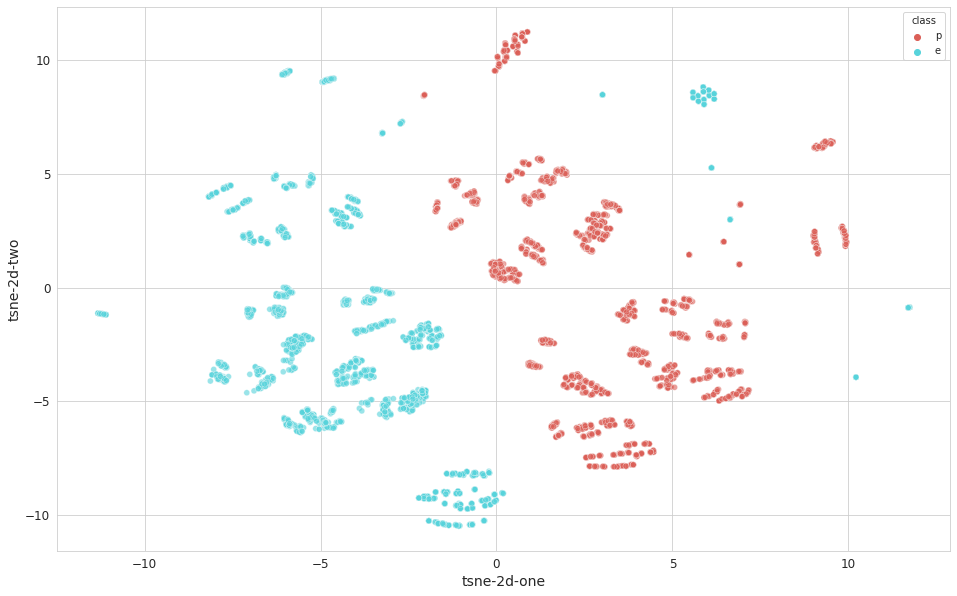

In [ ]:
# Plotting Clusters

data['tsne-2d-one'] = tsne_result[:, 0]
data['tsne-2d-two'] = tsne_result[:, 1]

plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='class',
               palette=sns.color_palette('hls', 2),
               data=data,
               alpha=0.6)


In [ ]:
# t-SNE along with PCA
from sklearn.decomposition import PCA


pca_20 = PCA(n_components=20)
tfmr = OneHotEncoder(sparse=False)
data_t=tfmr.fit_transform(data)
data_c=data_t[:,1:]

pca_result_20 = pca_20.fit_transform(data_c)
print('Cumulative explained variation for 20 principal components: {}'.format(np.sum(pca_20.explained_variance_ratio_)))

Cumulative explained variation for 20 principal components: 0.8124481480212121


In [ ]:
import time
from sklearn.manifold import TSNE
time_beg = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_20)
print('t-SNE on PCA_20 is complete! Time elapsed: {} seconds'.format(time.time()-time_beg))

t-SNE on PCA_20 is complete! Time elapsed: 30.065876483917236 seconds


In [ ]:
pca_tsne_df = pd.DataFrame(data = tsne_pca_results, columns = ['tsne_pca_PC1', 'tsne_pca_PC2'])
pca_tsne_df = pd.concat([pca_tsne_df, data['class']], axis = 1)
pca_tsne_df['class'] = LabelEncoder().fit_transform(pca_tsne_df['class'])
pca_tsne_df.head()

,tsne_pca_PC1,tsne_pca_PC2,class
0,-12.035322,5.260453,1
1,12.031904,-4.198960,0
2,13.908526,-3.494780,0
3,-12.566104,4.694971,1
4,10.020655,-8.797399,0


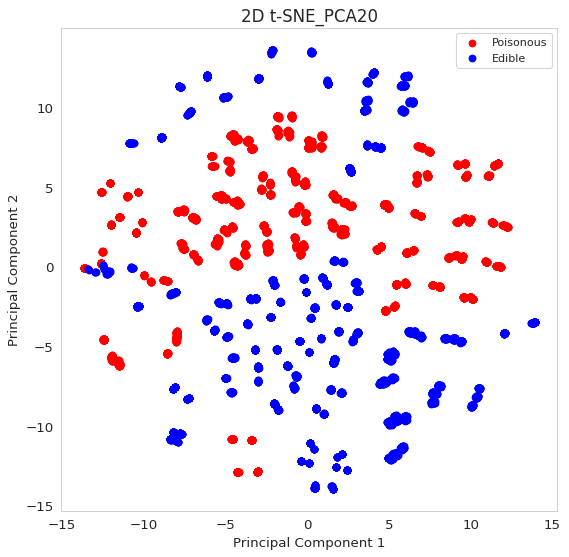

In [ ]:
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

classes = [1, 0]
colors = ['r', 'b']
for clas, color in zip(classes, colors):
    plt.scatter(pca_tsne_df.loc[pca_tsne_df['class'] == clas, 'tsne_pca_PC1'], pca_tsne_df.loc[pca_tsne_df['class'] == clas, 'tsne_pca_PC2'], c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D t-SNE_PCA20', fontsize = 15)
plt.legend(['Poisonous', 'Edible'])
plt.grid()

# ***Ensemble Method***

We tried three ensemble algorithms that for all of them we get high score.

In [ ]:
# Ensemble methods
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, criterion='entropy',min_samples_leaf=7), n_estimators=10,algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_tr, y_train)
y_ada_pred = ada_clf.predict(X_test_tr)
print(accuracy_score(y_test, y_ada_pred))


0.9895384615384616


In [ ]:
# ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier


forest = ExtraTreesClassifier(n_estimators=50,max_depth=11,criterion="gini")
forest.fit(X_train_tr, y_train)
y_ex_pred = forest.predict(X_test_tr)
print(accuracy_score(y_test, y_ex_pred))

0.9895384615384616


In [ ]:
# Random Forest 

# modifying binary variables to have numerical values
df = data.copy()

class_map = {'p': 1, 'e': 0}
df['class'] = df['class'].map(class_map)

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,True,p,f,c,n,k,e,e,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,True,a,f,c,b,k,e,c,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,True,l,f,c,b,n,e,c,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,True,p,f,c,n,n,e,e,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,False,n,f,w,b,k,t,e,s,s,w,w,w,o,e,n,a,g


In [ ]:
bruises_map = {True: 1, False: 0}
df['bruises'] = df['bruises'].map(bruises_map)

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,f,c,n,k,e,e,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,1,a,f,c,b,k,e,c,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,1,l,f,c,b,n,e,c,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,1,p,f,c,n,n,e,e,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,0,n,f,w,b,k,t,e,s,s,w,w,w,o,e,n,a,g


In [ ]:
X=df.iloc[:,1:]
y=df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6499, 21) (1625, 21) (6499,) (1625,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=0,
                      max_features='auto')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(ct, rf_classifier)
rndf_estimator = pipe.fit(X_train, y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

acc_score = accuracy_score(y_test, y_pred)

print(f"The accuracy of the model is {round(acc_score,3)*100} %")
print("RF accuracy : " + str(classification_report(rf_classifier.predict(X_f_test_tr), y_test)))

The accuracy of the model is 95.3 %
RF accuracy :               precision    recall  f1-score   support

           0       0.93      0.98      0.95       811
           1       0.98      0.93      0.95       814

    accuracy                           0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625



In [ ]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9967498294448529
Test ROC AUC  Score: 0.9968394888520429


Recall Baseline: 1.0 Test: 0.98 Train: 0.97
Precision Baseline: 0.48 Test: 0.93 Train: 0.93
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


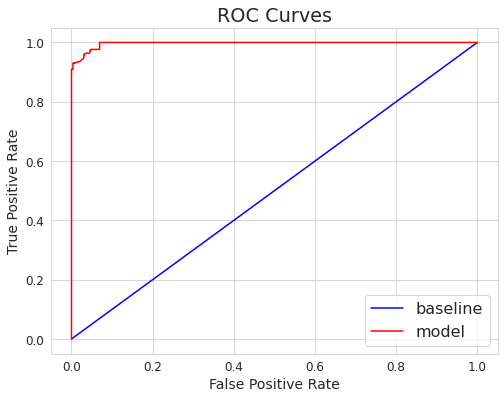

In [ ]:
baseline = {}
baseline['recall']= recall_score(y_test, [1 for _ in range(len(y_test))])
baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
baseline['roc'] = 0.5

results = {}
results['recall'] = recall_score(y_test, y_pred)
results['precision'] = precision_score(y_test, y_pred)
results['roc'] = roc_auc_score(y_test, probs)

train_results = {}
train_results['recall'] = recall_score(y_train, train_predictions)
train_results['precision'] = precision_score(y_train, train_predictions)
train_results['roc'] = roc_auc_score(y_train, train_probs)

for metric in ['recall', 'precision', 'roc']:            
  print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
              
  # Calculate false positive rates and true positive rates    
  base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
  model_fpr, model_tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize = (8, 6))

plt.rcParams['font.size'] = 16    

# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend() 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

Text(0.5, 48.90924432714948, 'Predicted label')

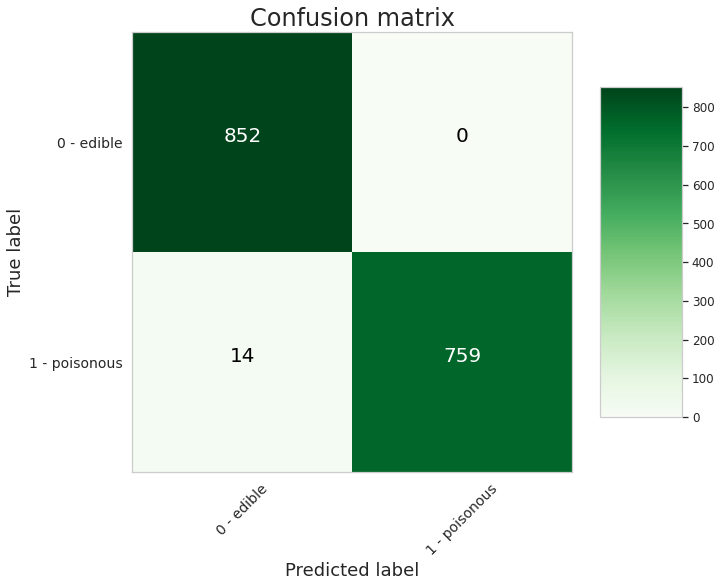

In [ ]:
import itertools

cm = confusion_matrix(y_test, y_pred)
classes = ['0 - edible', '1 - poisonous']
plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix', size = 24)
plt.colorbar(aspect=4)    
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 14)
plt.yticks(tick_marks, classes, size = 14)    
fmt = 'd'
thresh = cm.max() / 2.   
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt), 
          fontsize = 20,
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")
plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 18)
plt.xlabel('Predicted label', size = 18)

In [ ]:
print(rf_classifier.feature_importances_)
print(f"\n There are {len(rf_classifier.feature_importances_)} features in total")

[2.46593826e-03 7.12843946e-04 2.92970592e-05 0.00000000e+00
 8.89947525e-04 3.78979357e-03 0.00000000e+00 5.82205709e-03
 1.45086153e-03 3.18390025e-04 1.10485457e-03 5.85064312e-04
 4.10768779e-04 3.03873176e-04 0.00000000e+00 1.81099758e-03
 1.81864308e-03 3.01744502e-02 3.17831986e-02 2.84176205e-03
 4.48831030e-03 8.68853499e-02 4.50240853e-03 1.50939812e-01
 1.74034491e-02 2.45359915e-03 3.58133461e-03 1.03932968e-03
 3.44057599e-04 2.76642763e-02 1.76716794e-02 5.39242856e-02
 6.60755259e-02 3.76976732e-02 0.00000000e+00 3.68444230e-04
 5.75493515e-04 1.13935176e-05 4.83981827e-04 1.42053967e-04
 8.58741641e-04 6.68450129e-06 4.89527463e-04 1.00688036e-02
 1.30976726e-02 1.03429108e-02 1.42704471e-02 1.04556683e-02
 1.23586175e-02 2.17212874e-03 5.54647449e-03 4.09235205e-02
 2.18650325e-02 0.00000000e+00 1.49663107e-03 4.13609043e-02
 5.27937031e-03 1.88290021e-03 1.19494592e-03 1.36268991e-04
 9.72356822e-04 2.96036880e-03 9.53824482e-05 3.63681505e-04
 6.79877020e-03 2.524991

Note, rf_classifier.feature_importances_ prints all the encoded categorical variables. So, it is important to get the columns corresponding to these features by encoding the columns in the original dataframe.

In [ ]:
features_to_encode = [col for col in df.columns if col != 'class']

dummies = pd.get_dummies(df[features_to_encode])
res = pd.concat([dummies, df], axis=1)
X_train_encoded = res.drop(features_to_encode, axis=1)

feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))

# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Feature: {:25} Importance: {}'.format(*pair)) for pair in feature_importances_ranked]

Feature: odor_s                    Importance: 0.15093981176851637
Feature: odor_n                    Importance: 0.08688534987659466
Feature: gill-color_e              Importance: 0.0660755258687153
Feature: gill-color_b              Importance: 0.05392428556188559
Feature: stalk-surface-below-ring_y Importance: 0.04136090426899071
Feature: stalk-surface-above-ring_y Importance: 0.0409235204869715
Feature: spore-print-color_k       Importance: 0.040732428666230495
Feature: gill-color_g              Importance: 0.037697673209422265
Feature: spore-print-color_n       Importance: 0.03701173661786167
Feature: odor_cm                   Importance: 0.03178319864692873
Feature: odor_a                    Importance: 0.030174450160770073
Feature: gill-size_b               Importance: 0.027664276318694375
Feature: stalk-surface-below-ring_f Importance: 0.021865032460935005
Feature: habitat_d                 Importance: 0.019670619593756343
Feature: spore-print-color_h       Importance: 0.018509

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

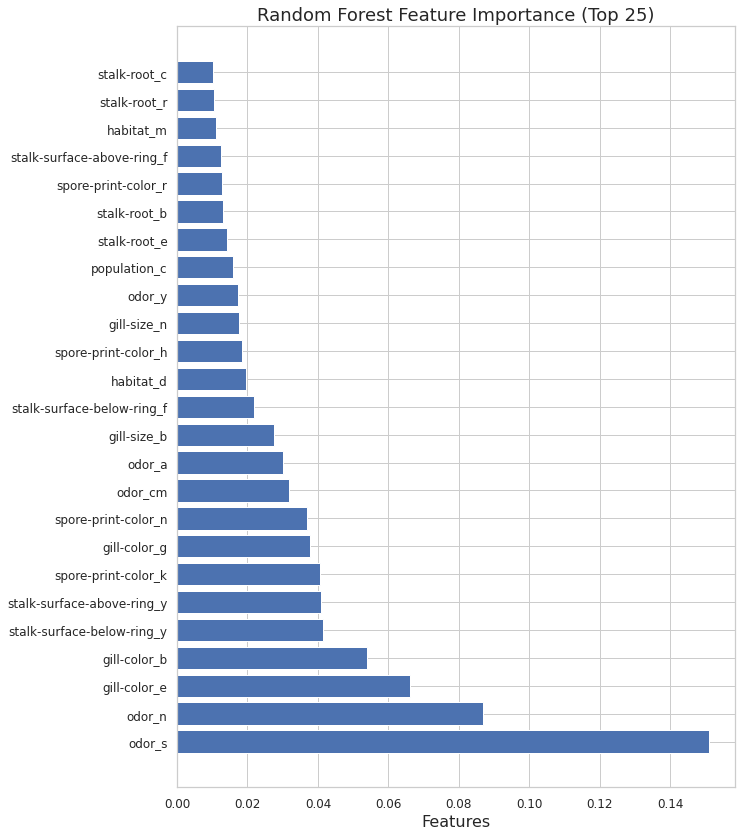

In [ ]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance (Top 25)')
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

# PCA Analysis 

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(123)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Splitting data

X=data.iloc[:,1:]
y=data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Preprocessing
# We have just categorical features and no missing data, so pipeline include just encoding:
var_cat=list(data.iloc[:,1:].columns)
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
cat_steps = [cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, var_cat)]

ct = ColumnTransformer(transformers=cat_transformers )
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6499, 22) (1625, 22) (6499,) (1625,)
(6499, 117) (1625, 117) (6499,) (1625,)


#SVM (no PCA)
As we can see with one hot encoding we have 117 columns. We will do a quick SVM test with no PCA. 

Classification_report: 
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       852
           p       1.00      1.00      1.00       773

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy score: 1.0


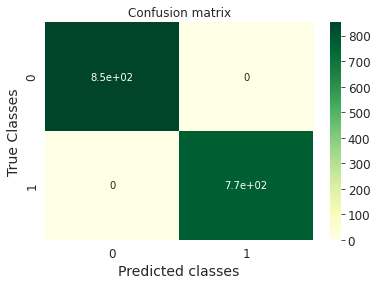

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

svm_clf = svm.SVC(kernel="linear", C=1)
svm_clf.fit(X_train, y_train)

# Scoring
print("Classification_report: \n" + str(classification_report(svm_clf.predict(X_test), y_test)))
print("Accuracy score: " + str(accuracy_score(svm_clf.predict(X_test), y_test)))

y_pr = svm_clf.predict(X_test)
plt.title('Confusion matrix')

sns.heatmap(confusion_matrix(y_test, y_pr), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

# PCA
Our threshold for variance will be quite high, since we do not want any poisonous mushrooms to be classified as edible. I chose to explain 99% of the variance. The columns have been reduced from 117 to 56. 

In [ ]:
# We are transforming after the split
# fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. 
# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data

#Reducing columns with PCA
pca = PCA(n_components=0.99)
X_pca_train = pca.fit_transform(X_train)

X_pca_test = pca.transform(X_test)

print(X_pca_train.shape, X_pca_test.shape, y_train.shape, y_test.shape)

(6499, 56) (1625, 56) (6499,) (1625,)


# PCA with SVM
he SVM results are the same as above. Therefore, using PCA was effective. 

Classification_report: 
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       852
           p       1.00      1.00      1.00       773

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy score: 1.0


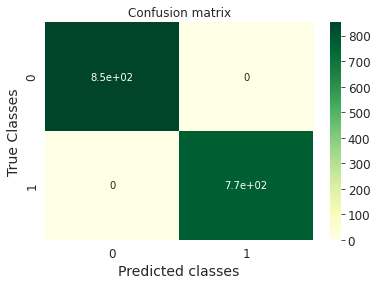

In [ ]:
# Fitting the SVM model 
svm_clf = svm.SVC(kernel="linear", C=1)
svm_clf.fit(X_pca_train, y_train)


# Scoring
print("Classification_report: \n" + str(classification_report(svm_clf.predict(X_pca_test), y_test)))
print("Accuracy score: " + str(accuracy_score(svm_clf.predict(X_pca_test), y_test)))

y_pr = svm_clf.predict(X_pca_test)
plt.title('Confusion matrix')

sns.heatmap(confusion_matrix(y_test, y_pr), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

# PCA with Logistic Regression
Now we will use PCA to explain 99% of the variance and use logistic regression. 

Fitting 3 folds for each of 999 candidates, totalling 2997 fits
{'max_iter': 14}
Classification_report: 
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       852
           p       1.00      1.00      1.00       773

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy score: 1.0


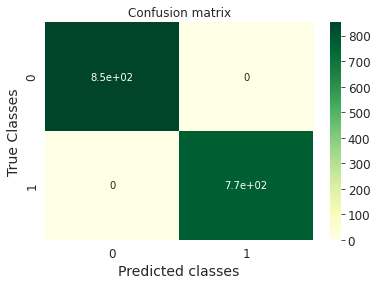

In [ ]:
# Logistic Regression Hyperparamether

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#param_grid={ "max_iter":[100,1000,2500,5000],"solver":["newton-cg", "lbfgs",  "sag", "saga"],"penalty":[ "l2", "none"]}
param_grid={"max_iter":list(range(1, 1000))} #reduced parameters because I kept getting errors 
lg_clf=GridSearchCV(LogisticRegression(),param_grid,n_jobs=-1,cv=3,verbose=True)
lg_clf.fit(X_pca_train,y_train)
print(lg_clf.best_params_)


# Scoring
print("Classification_report: \n" + str(classification_report(svm_clf.predict(X_pca_test), y_test)))
print("Accuracy score: " + str(accuracy_score(svm_clf.predict(X_pca_test), y_test)))

y_pr = svm_clf.predict(X_pca_test)
plt.title('Confusion matrix')

sns.heatmap(confusion_matrix(y_test, y_pr), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()